# [totoro.banrep](https://totoro.banrep.gov.co/estadisticas-economicas/)

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib as mpl
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 10
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf
import statsmodels.api as sm
from pandas.plotting import register_matplotlib_converters
import plotly.express as px
import plotly.graph_objects as go
import random 

In [2]:
# para correr código R en colab
%load_ext rpy2.ipython

## Tasa de interés, Crédito de consumo

Unidad: Tasa efectiva anual (porcentaje)

Fuente: Banco de la República, con información de la Superintendencia Financiera de Colombia
No incluye tarjetas de crédito.

In [3]:
tasa_M=pd.read_csv(r'https://raw.githubusercontent.com/jofmorenore/TimeSeries/master/proyecto/datos/Cr%C3%A9dito%20de%20consumo%20Tasa%20de%20inter%C3%A9s.csv')
tasa_S=pd.read_csv(r'https://raw.githubusercontent.com/jofmorenore/TimeSeries/master/proyecto/datos/Cr%C3%A9dito%20de%20consumo%20Tasa%20de%20inter%C3%A9s%20semanal.csv')

In [4]:
tasa_M['Fecha']=pd.to_datetime(tasa_M['Fecha'])
tasa_M['Fecha']=tasa_M['Fecha'].dt.date - pd.offsets.MonthBegin()
tasa_M=pd.Series(tasa_M['Porcentaje (%)'].values,tasa_M['Fecha'], name='tasa')
tasa_M.index.freq='MS'
tasa_M.head()

Fecha
2002-05-01    28.14
2002-06-01    27.87
2002-07-01    27.66
2002-08-01    27.44
2002-09-01    27.43
Freq: MS, Name: tasa, dtype: float64

In [5]:
tasa_S['Fecha']=pd.to_datetime(tasa_S['Fecha']).astype("datetime64[W]")
tasa_S=pd.Series(tasa_S['Porcentaje (%)'].values,tasa_S['Fecha'], name='tasa')
tasa_S.index.freq='W-FRI'
tasa_S.head()

Fecha
2002-05-03    28.20
2002-05-10    28.05
2002-05-17    28.25
2002-05-24    28.16
2002-05-31    28.05
Freq: W-FRI, Name: tasa, dtype: float64

In [6]:
[type(tasa_M), type(tasa_S)]

[pandas.core.series.Series, pandas.core.series.Series]

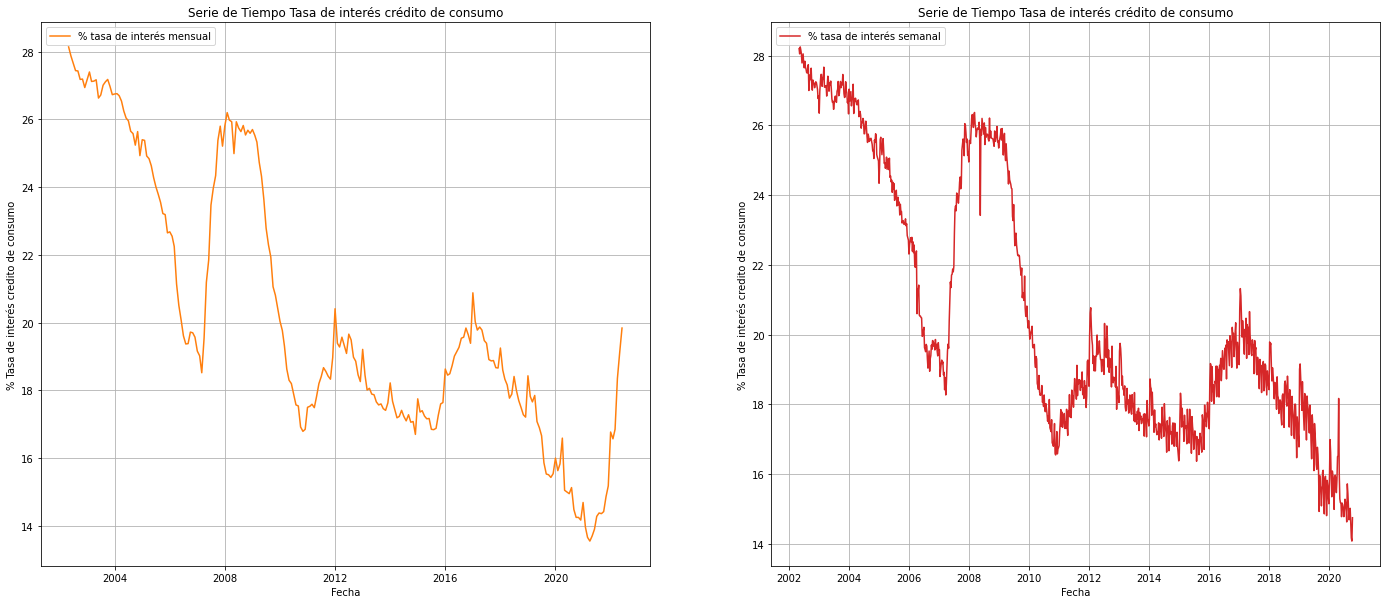

In [7]:
plt.rc('font', size=12)
fig, ax = plt.subplots(1,2,figsize=(24, 10))

ax[0].plot(tasa_M, color='tab:orange', label='% tasa de interés mensual')
ax[0].set_xlabel('Fecha')
ax[0].set_ylabel('% Tasa de interés credito de consumo')
ax[0].set_title('Serie de Tiempo Tasa de interés crédito de consumo')
ax[0].grid(True)
ax[0].legend(loc='upper left');

ax[1].plot(tasa_S, color='tab:red', label='% tasa de interés semanal')
ax[1].set_xlabel('Fecha')
ax[1].set_ylabel('% Tasa de interés credito de consumo')
ax[1].set_title('Serie de Tiempo Tasa de interés crédito de consumo')
ax[1].grid(True)
ax[1].legend(loc='upper left');

plt.show()

## Remesas de trabajadores, mensual

Unidad: Millones de USD

Fuente: Banco de la República

In [8]:
remesas = pd.read_csv(r'https://raw.githubusercontent.com/jofmorenore/TimeSeries/master/proyecto/datos/Serie%20agregada%20de%20Remesas%20de%20trabajadores.csv')

In [9]:
remesas['Fecha']=pd.to_datetime(remesas['Fecha'])
remesas['Fecha']=remesas['Fecha'].dt.date - pd.offsets.MonthBegin()
remesas=pd.Series(remesas['Millones de USD'].values,remesas['Fecha'], name='remesas')
remesas.index.freq='MS'
remesas.head()

Fecha
2000-01-01    103.751344
2000-02-01    145.837278
2000-03-01    125.347269
2000-04-01    115.880748
2000-05-01    129.341871
Freq: MS, Name: remesas, dtype: float64

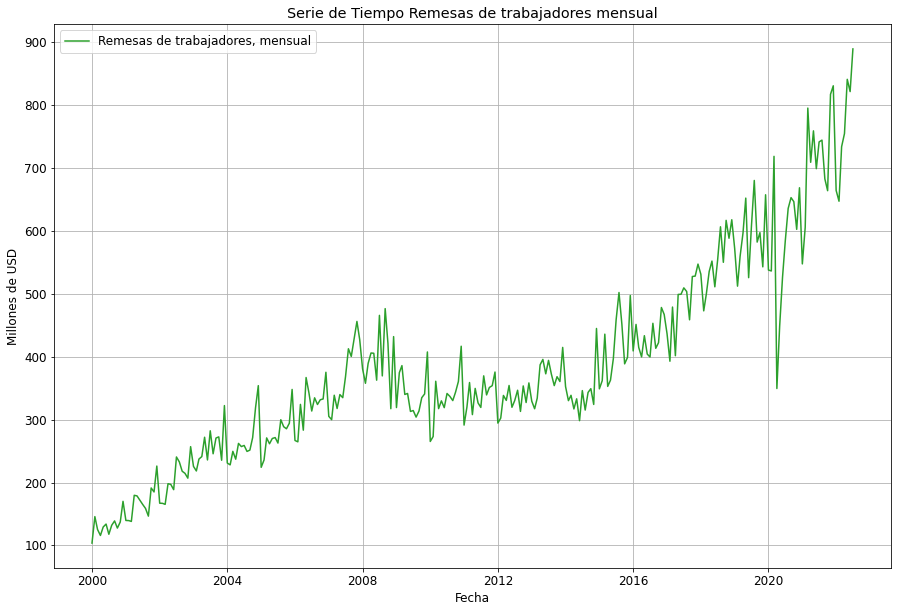

In [10]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(15, 10))

ax.plot(remesas, color='tab:green', label='Remesas de trabajadores, mensual')
ax.set_xlabel('Fecha')
ax.set_ylabel('Millones de USD')
ax.set_title('Serie de Tiempo Remesas de trabajadores mensual')
ax.grid(True)
ax.legend(loc='upper left');

Podemos observar una serie no estacionaria (la media difiere a lo largo del tiempo) con una tendencia estocástica (la cual no es una función suave) creciente, además de varianza marginal no constante, la serie diferenciada nos permitirá determinar si hay presencia de ciclos ocultos en la serie.




+ **ACF plot**

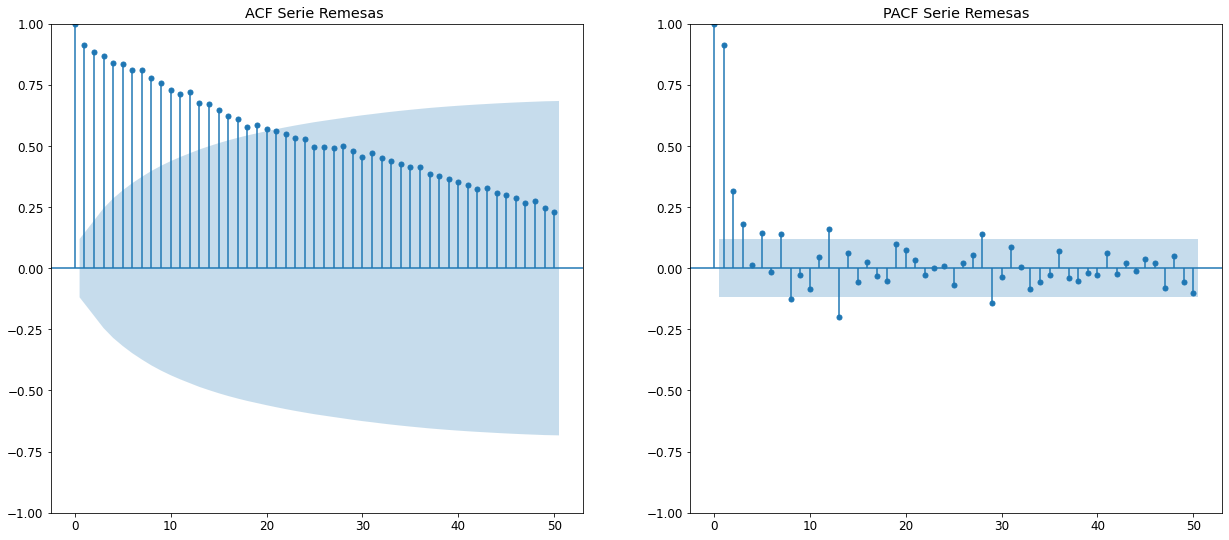

In [11]:
fig, ax = plt.subplots(1,2,figsize=(21,9))
plot_acf(remesas,adjusted=False,lags=50,ax=ax[0],title='ACF Serie Remesas ')
plot_pacf(remesas,lags=50,ax=ax[1],title='PACF Serie Remesas', method='ywmle')
plt.show()

El gráfico de la función de autocorrelación evidencia que en los rezagos 1 y 12 el valor del coeficiente es alto lo sugiere una fuerte asociación estadística tanto negativa como postiva respectivamente, además a traves del gráfico se determina nuevamente que la serie no es estacionaria porque no se va rápidamente a cero.

+ **Transformación Box-Cox**

In [12]:
import scipy as sp
import scipy.stats 
sp.stats.boxcox(remesas,alpha=0.05) #(0.058, 0.522) #Data must be positive

(array([ 9.76761319, 11.1344932 , 10.51008057, 10.19681686, 10.63722743,
        10.78210855, 10.26142549, 10.72354002, 10.93330437, 10.5831735 ,
        10.87940283, 11.79897059, 10.9550986 , 10.94927701, 10.90979771,
        12.04240013, 12.019185  , 11.84493574, 11.67260959, 11.50008528,
        11.15714431, 12.32601601, 12.1736716 , 13.10733419, 11.72165756,
        11.71543741, 11.67325283, 12.48606965, 12.45977641, 12.26210348,
        13.4065363 , 13.24659283, 12.93100314, 12.85863014, 12.68804634,
        13.7306921 , 13.09632121, 12.94087697, 13.33907647, 13.41930171,
        14.01372878, 13.30996076, 14.2012351 , 13.50837309, 13.99040861,
        14.02445844, 13.30013851, 14.8917562 , 13.20827222, 13.1474622 ,
        13.58475318, 13.33466417, 13.82897646, 13.73312792, 13.7675962 ,
        13.58285802, 13.62353223, 14.0044453 , 14.83397619, 15.39562494,
        13.06509909, 13.309225  , 13.99416495, 13.81909129, 13.97691438,
        14.00392368, 13.84013454, 14.5125496 , 14.3

In [13]:
%%R
#install.packages("forecast")
#install.packages("FitAR")

NULL


In [ ]:
%%R
library(forecast)
#library(FitAR) # genera error en colab

In [15]:
# -i pasar los datos de entorno python a R (analogamente -o: pasar los datos de entrono R a python)
%R -i remesas

In [16]:
%%R 
forecast::BoxCox.lambda(remesas, method = "guerrero", lower = -1, upper = 3)

[1] 0.08589458


In [17]:
bc_remesas=sp.stats.boxcox(remesas,lmbda=0.08589458).rename('BC_remesas')
remesas2 = pd.concat([remesas, bc_remesas], axis=1)
remesas2.head()

,remesas,BC_remesas
Fecha,,
2000-01-01,103.751344,5.703735
2000-02-01,145.837278,6.218536
2000-03-01,125.347269,5.987766
2000-04-01,115.880748,5.869252
2000-05-01,129.341871,6.035336


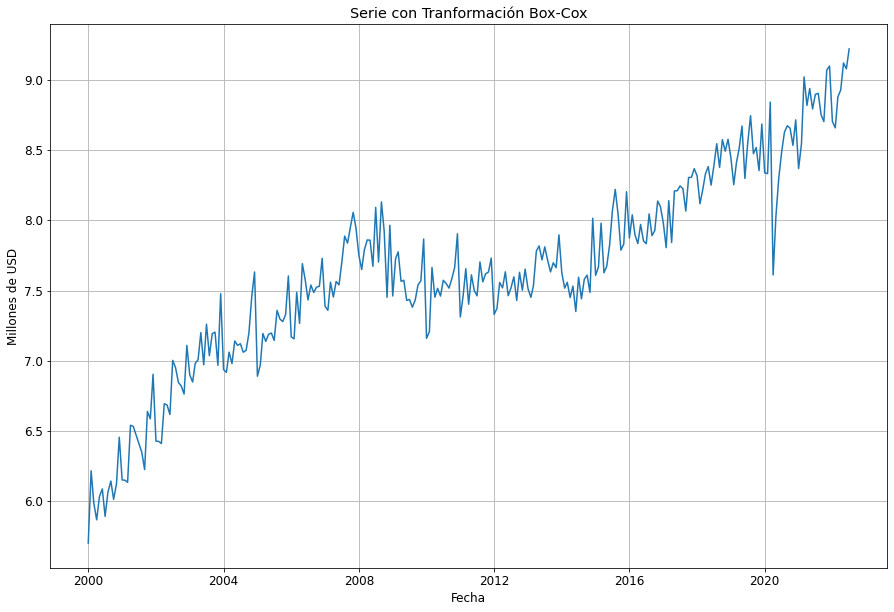

In [18]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(15, 10))

plt.plot(remesas2['BC_remesas'])
plt.title('Serie con Tranformación Box-Cox') 
ax.set_xlabel('Fecha')
ax.set_ylabel('Millones de USD')
ax.grid(True)
plt.show()

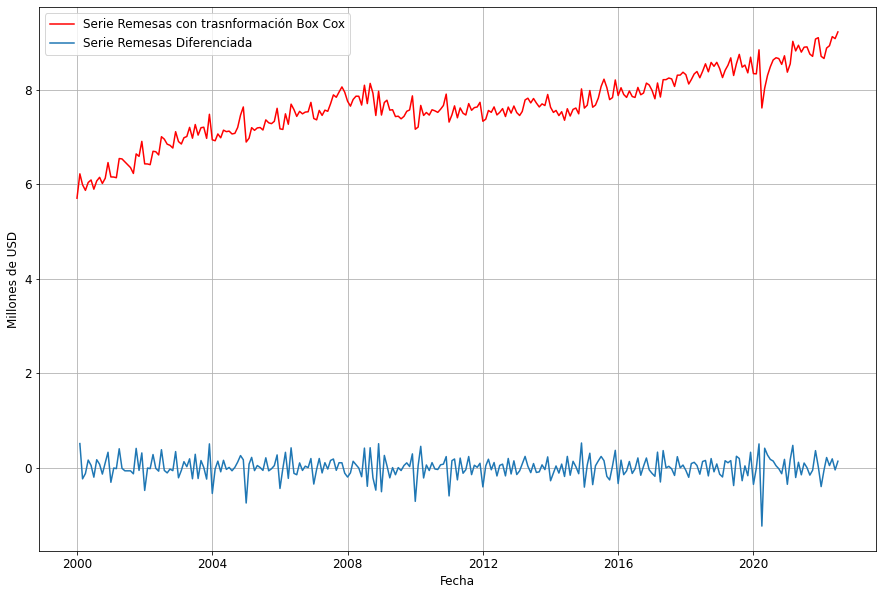

In [19]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(15, 10))

dif_remesas=remesas2['BC_remesas'].diff(periods=1)
ax.plot(remesas2['BC_remesas'], 'r', label="Serie Remesas con trasnformación Box Cox")
ax.plot(dif_remesas, '-', label="Serie Remesas Diferenciada")
ax.set_xlabel('Fecha')
ax.set_ylabel('Millones de USD')
ax.grid(True)
ax.legend(loc="best");

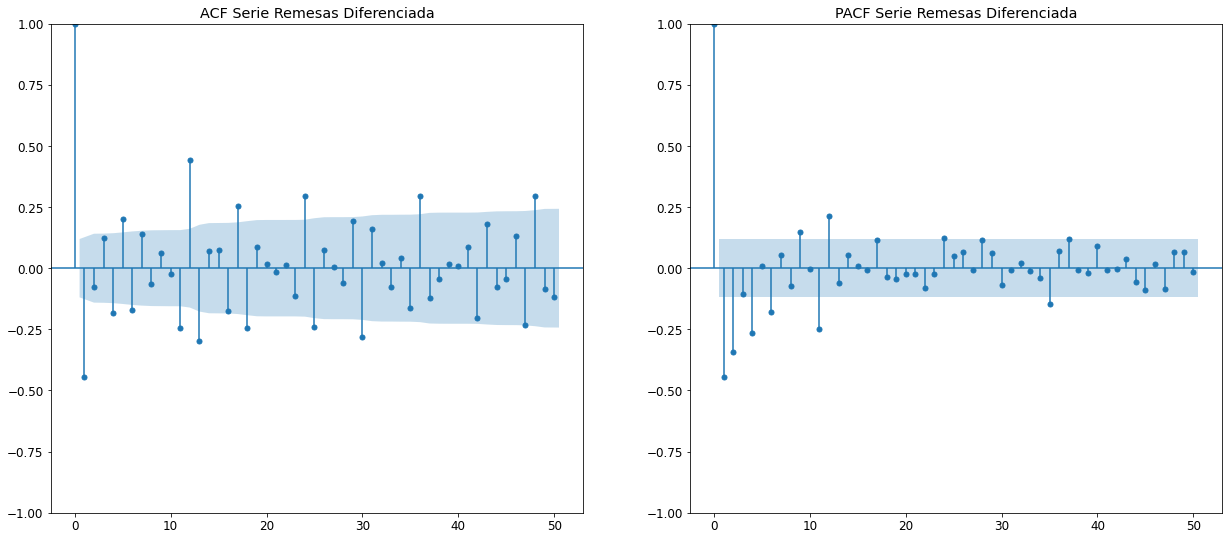

In [20]:
fig, ax = plt.subplots(1,2,figsize=(21,9))
plot_acf(dif_remesas.dropna(),adjusted=False,lags=50,ax=ax[0],title='ACF Serie Remesas Diferenciada')
plot_pacf(dif_remesas.dropna(),lags=50,ax=ax[1],title='PACF Serie Remesas Diferenciada', method='ywmle')
plt.show()

## Inflación total anual

Unidad: Variación anual

Fuente: Departamento Administrativo Nacional de Estadística (DANE)
La inflación se define como la variación porcentual del IPC entre dos periodos. En particular la inflación anual se mide tomando el IPC de un mes y calculando su variación frente al dato del mismo mes del año anterior.

In [21]:
inflacion_M = pd.read_csv(r'https://raw.githubusercontent.com/jofmorenore/TimeSeries/master/proyecto/datos/Inflaci%C3%B3n%20total.csv')
inflacion_A = pd.read_csv(r'https://raw.githubusercontent.com/jofmorenore/TimeSeries/master/proyecto/datos/inflaci%C3%B3n%20total%20anual.csv')

In [22]:
inflacion_M['Fecha']=pd.to_datetime(inflacion_M['Fecha'])
inflacion_M['Fecha']=inflacion_M['Fecha'].dt.date - pd.offsets.MonthBegin()
inflacion_M=pd.Series(inflacion_M['Porcentaje (%)'].values,inflacion_M['Fecha'], name='inflación')
inflacion_M.index.freq='MS'
inflacion_M.head()

Fecha
1955-07-01   -0.87
1955-08-01   -0.01
1955-09-01    0.84
1955-10-01    0.77
1955-11-01    1.44
Freq: MS, Name: inflación, dtype: float64

In [23]:
inflacion_A['Fecha']=pd.to_datetime(inflacion_A['Fecha']).astype("datetime64[Y]")
inflacion_A=pd.Series(inflacion_A['Porcentaje (%)'].values,inflacion_A['Fecha'], name='inflación')
inflacion_A.index.freq='Y'
inflacion_A.head()

Fecha
1955-12-31     2.03
1956-12-31     7.91
1957-12-31    20.69
1958-12-31     7.98
1959-12-31     7.81
Freq: A-DEC, Name: inflación, dtype: float64

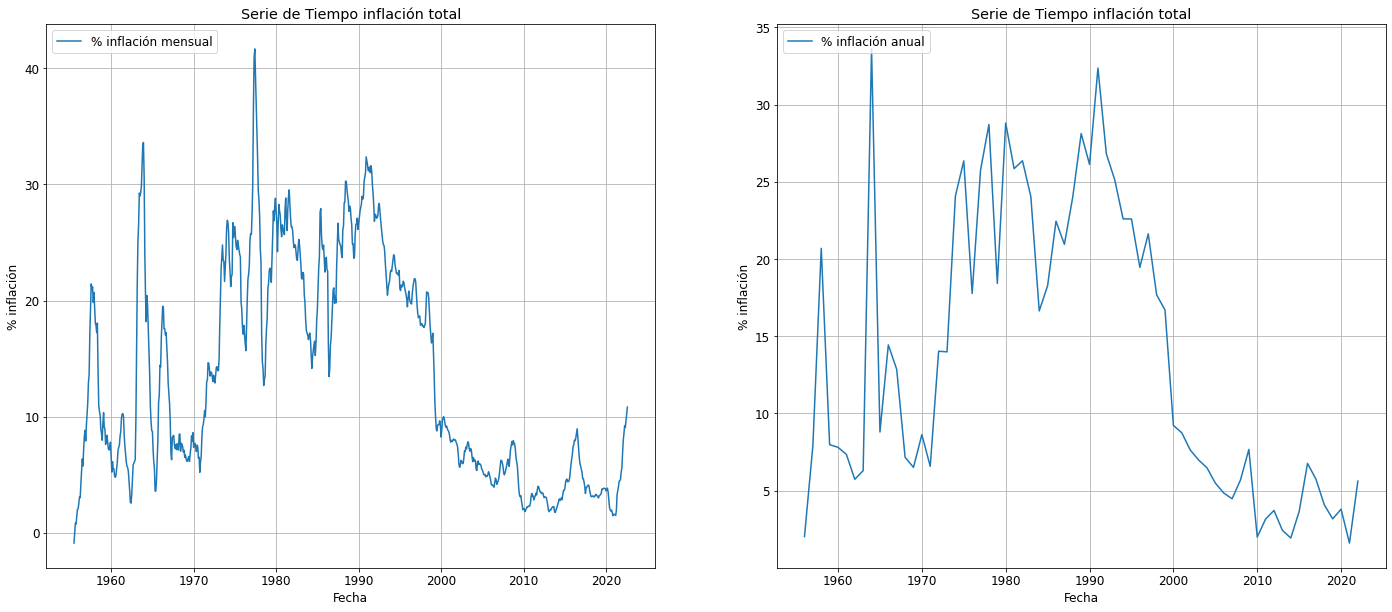

In [24]:
plt.rc('font', size=12)
fig, ax = plt.subplots(1,2,figsize=(24, 10))

ax[0].plot(inflacion_M, color='tab:blue', label='% inflación mensual')
ax[0].set_xlabel('Fecha')
ax[0].set_ylabel('% inflación')
ax[0].set_title('Serie de Tiempo inflación total')
ax[0].grid(True)
ax[0].legend(loc='upper left')

ax[1].plot(inflacion_A, color='tab:blue', label='% inflación anual')
ax[1].set_xlabel('Fecha')
ax[1].set_ylabel('% inflación')
ax[1].set_title('Serie de Tiempo inflación total')
ax[1].grid(True)
ax[1].legend(loc='upper left')

plt.show()